In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
engine_manufacturers = pd.read_csv( "./dataset/engine_manufacturers_processed.csv")
races = pd.read_csv("./dataset/races.csv")
constructor_resultf = pd.read_csv('dataset/constructor_results.csv')
constructors = pd.read_csv('dataset/constructors.csv')
constructor_standings = pd.read_csv('dataset/constructor_standings.csv')
engine_manufacturers = pd.read_csv( 'dataset/engine_manufacturers_processed.csv')

In [3]:
# Before we get to the good stuff, we need to do a little data wrangling so we can see the results of 
# each constructor at the end of the year.
# Our data is separated like an SQL database, so we'll have to use a few joins/merges.

# We have engine manufacturer data between 2010-2020, so we need to filter races
# so they fall in the same timeframe.
races = races[(2010 <= races['year']) & (races['year'] <= 2020)]
races = races[['raceId', 'year']]   # Only need these two columns.
# display(races[races['year'] == 2010])

constructor_standings_by_race = pd.merge(races, constructor_standings[['constructorId', 'raceId', 'points', 'wins']], on=['raceId'], how='left')
# display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

constructor_standings_by_race = pd.merge(constructor_standings_by_race, engine_manufacturers, on=[ 'year', 'constructorId'], how='left')
# display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

constructor_standings_by_race = pd.merge( constructor_standings_by_race, constructors[['constructorId', 'name']], on=['constructorId'], how='left')

# This should display the raceId, year, constructorId, points,
# engine_manufacturer, name (of the team) for just one race in one year.
display( constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

,raceId,year,constructorId,points,wins,engine_manufacturer,name
0,337,2010,6,43.0,1,Ferrari,Ferrari
1,337,2010,1,21.0,0,Mercedes,McLaren
2,337,2010,9,16.0,0,Renault,Red Bull
3,337,2010,131,18.0,0,Mercedes,Mercedes
4,337,2010,10,2.0,0,Mercedes,Force India
5,337,2010,3,1.0,0,Cosworth,Williams
6,337,2010,4,0.0,0,Renault,Renault
7,337,2010,5,0.0,0,Ferrari,Toro Rosso
8,337,2010,205,0.0,0,Cosworth,Lotus
9,337,2010,15,0.0,0,Ferrari,Sauber


In [4]:
# Note that there are some teams that changed their names in the 2010-2020 period, so we must account for that.
# Note that thte original dataset calls the team 'Alpha Tauri' 'AlphaTauri', so we need to account for that in the name change too.
old_to_new_names = {
    'Force India': 'Racing Point',
    'Toro Rosso': 'AlphaTauri',
    'Sauber': 'Alfa Romeo',
    'Lotus': 'Renault',
    'Marussia': 'Manor Marussia'
}

display(constructor_standings_by_race)
constructor_standings_by_race['name'] = constructor_standings_by_race['name'].replace(old_to_new_names)

# Notice how 'Force India' becomes 'Racing Point' in the fifth row in 2010.
display(constructor_standings_by_race)

,raceId,year,constructorId,points,wins,engine_manufacturer,name
0,337,2010,6,43.0,1,Ferrari,Ferrari
1,337,2010,1,21.0,0,Mercedes,McLaren
2,337,2010,9,16.0,0,Renault,Red Bull
3,337,2010,131,18.0,0,Mercedes,Mercedes
4,337,2010,10,2.0,0,Mercedes,Force India
...,...,...,...,...,...,...,...
2316,1047,2020,4,181.0,0,Renault,Renault
2317,1047,2020,51,8.0,0,Ferrari,Alfa Romeo
2318,1047,2020,3,0.0,0,Mercedes,Williams
2319,1047,2020,9,319.0,2,Honda,Red Bull


,raceId,year,constructorId,points,wins,engine_manufacturer,name
0,337,2010,6,43.0,1,Ferrari,Ferrari
1,337,2010,1,21.0,0,Mercedes,McLaren
2,337,2010,9,16.0,0,Renault,Red Bull
3,337,2010,131,18.0,0,Mercedes,Mercedes
4,337,2010,10,2.0,0,Mercedes,Racing Point
...,...,...,...,...,...,...,...
2316,1047,2020,4,181.0,0,Renault,Renault
2317,1047,2020,51,8.0,0,Ferrari,Alfa Romeo
2318,1047,2020,3,0.0,0,Mercedes,Williams
2319,1047,2020,9,319.0,2,Honda,Red Bull


In [5]:
# Since the points field from `constructor_standings` accumulates over the races
# in a year, we can get the points at the last race to get the total points a
# team got in a year.
grouped = constructor_standings_by_race.groupby( ['year', 'name', 'engine_manufacturer']).max(['name'])
df: pd.DateOffset = grouped.reset_index()

In [11]:
# Now, let's filter out a list of all teams that manufacture their own engines (team name == engine manufacturer name).
matches: pd.Series = df.groupby('name').apply(lambda x: (x['name'] == x['engine_manufacturer']).sum())
display(matches)

# Only a few teams actually manufacture their own engines consistently, let's filter them out.
self_manufacturing_teams = list(matches[matches > 1].keys())

print(f"Teams that make their own engines: {self_manufacturing_teams}")


name
Alfa Romeo         1
AlphaTauri         0
Caterham           0
Ferrari           11
HRT                0
Haas F1 Team       0
Manor Marussia     0
McLaren            0
Mercedes          11
Racing Point       0
Red Bull           0
Renault            7
Virgin             0
Williams           0
dtype: int64

Teams that make their own engines: ['Ferrari', 'Mercedes', 'Renault']


In [12]:

# Then we plot the points or wins of all teams, the ones making their own engines are solid, everyone else is dashed.
def plot_by_year(dataframe, y_axis_data_name, y_axis_plot_name, title):
    fig,ax = plt.subplots()
    fig.set_dpi(200)
    fig.set_size_inches(10, 5)

    for name in dataframe['name'].unique():
        ax.plot(
            dataframe[dataframe.name==name].year,
            dataframe[dataframe.name==name][y_axis_data_name],
            label=name, 
            linestyle='dashed' if name not in self_manufacturing_teams else 'solid'
        )

    ax.set_xlabel("Year")
    ax.set_ylabel(y_axis_plot_name)
    ax.legend(loc='best')
    plt.title(title)


In [13]:
for name in df['name'].unique():
    display(df[df['name'] == name][['year', 'name', 'engine_manufacturer', 'wins', 'points']])

,year,name,engine_manufacturer,wins,points
0,2010,Alfa Romeo,Ferrari,0,44.0
12,2011,Alfa Romeo,Ferrari,0,44.0
22,2012,Alfa Romeo,Ferrari,0,126.0
33,2013,Alfa Romeo,Ferrari,0,57.0
43,2014,Alfa Romeo,Ferrari,0,0.0
53,2015,Alfa Romeo,Ferrari,0,36.0
62,2016,Alfa Romeo,Ferrari,0,2.0
73,2017,Alfa Romeo,Ferrari,0,5.0
83,2018,Alfa Romeo,Alfa Romeo,0,48.0
93,2019,Alfa Romeo,Ferrari,0,57.0


,year,name,engine_manufacturer,wins,points
1,2010,AlphaTauri,Ferrari,0,13.0
13,2011,AlphaTauri,Ferrari,0,41.0
23,2012,AlphaTauri,Ferrari,0,26.0
34,2013,AlphaTauri,Ferrari,0,33.0
44,2014,AlphaTauri,Renault,0,30.0
54,2015,AlphaTauri,Renault,0,67.0
63,2016,AlphaTauri,Ferrari,0,63.0
74,2017,AlphaTauri,Renault,0,53.0
84,2018,AlphaTauri,Honda,0,33.0
94,2019,AlphaTauri,Honda,0,85.0


,year,name,engine_manufacturer,wins,points
2,2010,Ferrari,Ferrari,5,396.0
14,2011,Ferrari,Ferrari,1,375.0
25,2012,Ferrari,Ferrari,3,400.0
36,2013,Ferrari,Ferrari,2,354.0
46,2014,Ferrari,Ferrari,0,216.0
55,2015,Ferrari,Ferrari,3,428.0
64,2016,Ferrari,Ferrari,0,398.0
75,2017,Ferrari,Ferrari,5,522.0
85,2018,Ferrari,Ferrari,6,571.0
95,2019,Ferrari,Ferrari,3,504.0


,year,name,engine_manufacturer,wins,points
3,2010,HRT,Cosworth,0,0.0
15,2011,HRT,Cosworth,0,0.0
26,2012,HRT,Cosworth,0,0.0


,year,name,engine_manufacturer,wins,points
4,2010,McLaren,Mercedes,5,454.0
16,2011,McLaren,Mercedes,6,497.0
28,2012,McLaren,Mercedes,7,378.0
38,2013,McLaren,Mercedes,0,122.0
48,2014,McLaren,Mercedes,0,181.0
57,2015,McLaren,Honda,0,27.0
67,2016,McLaren,Honda,0,76.0
77,2017,McLaren,Honda,0,30.0
87,2018,McLaren,Renault,0,62.0
97,2019,McLaren,Renault,0,145.0


,year,name,engine_manufacturer,wins,points
5,2010,Mercedes,Mercedes,0,214.0
17,2011,Mercedes,Mercedes,0,165.0
29,2012,Mercedes,Mercedes,1,142.0
39,2013,Mercedes,Mercedes,3,360.0
49,2014,Mercedes,Mercedes,16,701.0
58,2015,Mercedes,Mercedes,16,703.0
68,2016,Mercedes,Mercedes,19,765.0
78,2017,Mercedes,Mercedes,12,668.0
88,2018,Mercedes,Mercedes,11,655.0
98,2019,Mercedes,Mercedes,15,739.0


,year,name,engine_manufacturer,wins,points
6,2010,Racing Point,Mercedes,0,68.0
18,2011,Racing Point,Mercedes,0,69.0
30,2012,Racing Point,Mercedes,0,109.0
40,2013,Racing Point,Mercedes,0,77.0
50,2014,Racing Point,Mercedes,0,155.0
59,2015,Racing Point,Mercedes,0,136.0
69,2016,Racing Point,Mercedes,0,173.0
79,2017,Racing Point,Mercedes,0,187.0
89,2018,Racing Point,Mercedes,0,59.0
99,2019,Racing Point,Mercedes,0,73.0


,year,name,engine_manufacturer,wins,points
7,2010,Red Bull,Renault,9,498.0
19,2011,Red Bull,Renault,12,650.0
31,2012,Red Bull,Renault,7,460.0
41,2013,Red Bull,Renault,13,596.0
51,2014,Red Bull,Renault,3,405.0
60,2015,Red Bull,Renault,0,187.0
70,2016,Red Bull,Renault,2,468.0
80,2017,Red Bull,Renault,3,368.0
90,2018,Red Bull,Renault,4,419.0
100,2019,Red Bull,Honda,3,417.0


,year,name,engine_manufacturer,wins,points
8,2010,Renault,Cosworth,0,0.0
9,2010,Renault,Renault,0,163.0
20,2011,Renault,Renault,0,73.0
71,2016,Renault,Renault,0,8.0
81,2017,Renault,Renault,0,57.0
91,2018,Renault,Renault,0,122.0
101,2019,Renault,Renault,0,91.0
111,2020,Renault,Renault,0,181.0


,year,name,engine_manufacturer,wins,points
10,2010,Virgin,Cosworth,0,0.0


,year,name,engine_manufacturer,wins,points
11,2010,Williams,Cosworth,0,69.0
21,2011,Williams,Cosworth,0,5.0
32,2012,Williams,Renault,1,76.0
42,2013,Williams,Renault,0,5.0
52,2014,Williams,Mercedes,0,320.0
61,2015,Williams,Mercedes,0,257.0
72,2016,Williams,Mercedes,0,138.0
82,2017,Williams,Mercedes,0,83.0
92,2018,Williams,Mercedes,0,7.0
102,2019,Williams,Mercedes,0,1.0


,year,name,engine_manufacturer,wins,points
24,2012,Caterham,Renault,0,0.0
35,2013,Caterham,Renault,0,0.0
45,2014,Caterham,Renault,0,0.0


,year,name,engine_manufacturer,wins,points
27,2012,Manor Marussia,Cosworth,0,0.0
37,2013,Manor Marussia,Cosworth,0,0.0
47,2014,Manor Marussia,Ferrari,0,2.0
56,2015,Manor Marussia,Ferrari,0,0.0
66,2016,Manor Marussia,Mercedes,0,1.0


,year,name,engine_manufacturer,wins,points
65,2016,Haas F1 Team,Ferrari,0,29.0
76,2017,Haas F1 Team,Ferrari,0,47.0
86,2018,Haas F1 Team,Ferrari,0,93.0
96,2019,Haas F1 Team,Ferrari,0,28.0
106,2020,Haas F1 Team,Ferrari,0,3.0


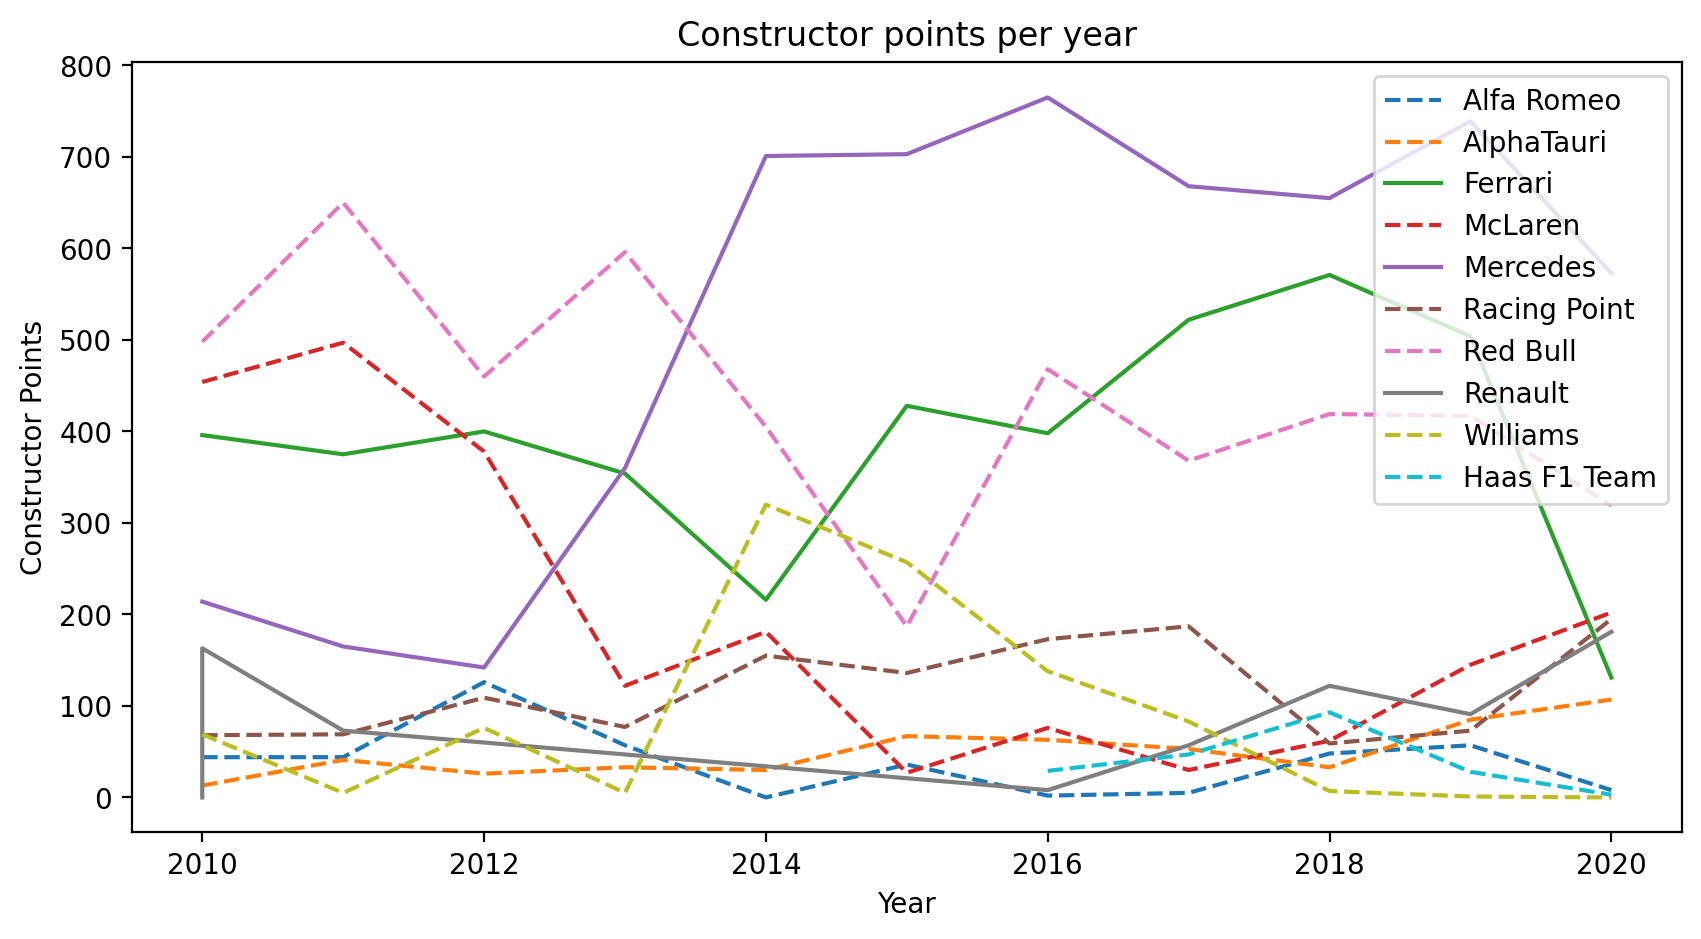

In [14]:

# Some teams can't be seen properly on the points graph due to their low scores.
# These teams are: HRT, Virgin, Caterham, Manor Marussiaa.
teams_to_drop = ['HRT', 'Virgin', 'Caterham', 'Manor Marussia']
points = df[~df['name'].isin(teams_to_drop)]

# Expectation: Teams that manufacture their own engines should perform better.
# Observation: Not really, we have 3 teams that make their own engine visible on
# the plot (Mercedes, Ferrari, Renault). Ferrari and Mercedes seem to usually do
# well, but Renault doesnt't consistently outperform teams that don't make their
# own engines.
plot_by_year(points, 'points', 'Constructor Points', 'Constructor points per year')

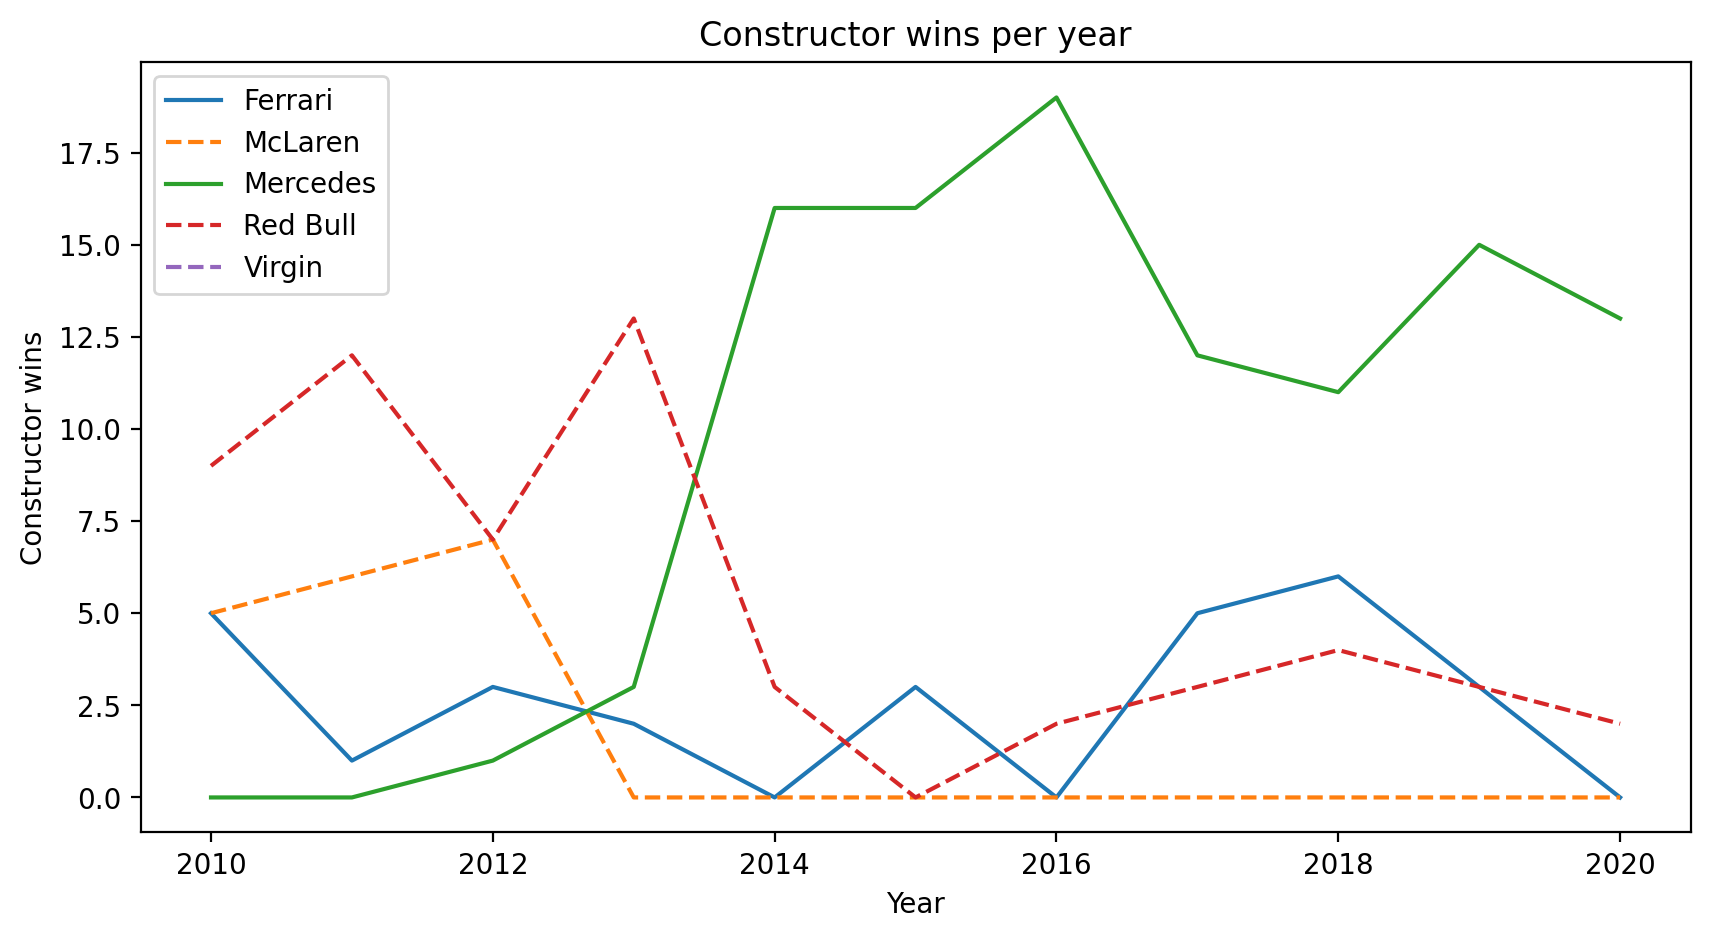

In [15]:

# Most teams have no wins and form a straight line at zero, we can also remove those for plotting.
# These teams are: Alfa Romeo, AlphaTauri, Renault, Haas F1 Team.
teams_to_drop = ['Alfa Romeo', 'AlphaTauri', 'Renault', 'Haas F1 Team', 'Williams', 'Racing Point', 'AlphaTauri', 'Manor Marussia', 'Caterham', 'HRT']
wins = df[~df['name'].isin(teams_to_drop)]

# Expectation: Teams that make their own engines should have more wins.
# Observations: Renault doesn't even show up in the plot, while Mercedes and
# Ferrari usually perform better than average.
plot_by_year(wins, 'wins', 'Constructor wins', 'Constructor wins per year')